# Environment Setup

In [1]:
import torch
import os

print("\n--- DETECTING ENVIRONMENT ---")

# 1. Detect PyTorch and CUDA versions
torch_ver = torch.__version__
cuda_ver = torch.version.cuda

print(f"PyTorch Version: {torch_ver}")
print(f"CUDA Version:   {cuda_ver}")

# 2. Determine Correct Wheel Source
base_ver = torch_ver.split('+')[0]

# Check if CUDA is available
if cuda_ver is None:
    print("\n⚠️ CUDA not detected. Using CPU wheels.")
    url = f"https://data.pyg.org/whl/torch-{base_ver}+cpu.html"
else:
    cuda_suffix = f"cu{cuda_ver.replace('.', '')}"
    url = f"https://data.pyg.org/whl/torch-{base_ver}+{cuda_suffix}.html"

print(f"\n--- INSTALLING FROM: {url} ---\n")

# 3. Install PyTorch Geometric Dependencies

# Required low-level ops:
cmd1 = f"pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f {url}"
print(f"Installing PyG ops:\n{cmd1}\n")
os.system(cmd1)

# Install pyg-lib 
cmd2 = f"pip install pyg-lib -f {url}"
print(f"Installing pyg-lib:\n{cmd2}\n")
os.system(cmd2)

# Install main PyG library
cmd3 = "pip install torch-geometric"
print(f"Installing torch-geometric:\n{cmd3}\n")
os.system(cmd3)

print("\n✅ All the Installation Complete.")



--- DETECTING ENVIRONMENT ---
PyTorch Version: 2.8.0+cu126
CUDA Version:   12.6

--- INSTALLING FROM: https://data.pyg.org/whl/torch-2.8.0+cu126.html ---

Installing PyG ops:
pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.8.0+cu126.html

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 107.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 96.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.8 MB/s eta 0:00:00
Installing pyg-lib:
pip install pyg-lib -f https://data.pyg.org/whl/torch-2.8.0+cu126.html

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 39.4 MB/s eta 0:00:00
Installing torch-geometric:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━

# **Config and Helpers**

In [2]:
import os, time, math
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import networkx as nx
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_recall_curve, auc, f1_score, classification_report
import xgboost as xgb
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, HeteroConv, Linear
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig
import shap
import warnings
warnings.filterwarnings("ignore")

# ----CONFIG-------
# Architectural capacity
HIDDEN_DIM = 32
CONV_LAYERS = 2
DROPOUT = 0.3
EDGE_DROPOUT_P = 0.10
CHUNK_SIZE = 65536

# Optimization-stability
LR = 1e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 30
PATIENCE = 6

# Data-dependent
P_POS_MULTIPLIER = 8
FOCAL_GAMMA = 1.5
FOCAL_ALPHA = 0.4

# ---------Helpers---------
def pr_auc_from_probs(y_true, y_scores):
    """Return PR-AUC (area under precision-recall curve)."""
    if len(y_true) == 0:
        return 0.0
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

def chunks(arr, size):
    for i in range(0, len(arr), size):
        yield arr[i:i+size]

def drop_edges(edge_index, p=0.0):
    if p <= 0.0:
        return edge_index
    E = edge_index.size(1)
    if E == 0:
        return edge_index
    keep_mask = torch.rand(E, device=edge_index.device) >= p
    if keep_mask.all():
        return edge_index
    return edge_index[:, keep_mask]

# **Download & Load Data**

In [3]:
try:
    path = "/kaggle/input/paysim1"
    file_path = os.path.join(path, "PS_20174392719_1491204439457_log.csv")
    if not os.path.exists(file_path):
        raise FileNotFoundError
    print("Found attached dataset.")
except FileNotFoundError:
    path = kagglehub.dataset_download("ealaxi/paysim1")
    file_path = os.path.join(path, "PS_20174392719_1491204439457_log.csv")
    print("Dataset not found. Downloaded via KaggleHub.")

df = pd.read_csv(file_path)
df.head()

Found attached dataset.


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Exploratory Data analysis (EDA)

In [4]:
print("\n--- FRAUD DISTRIBUTION ANALYSIS ---")
eda_table = df.groupby('type')['isFraud'].agg(['count', 'sum']).reset_index()
eda_table.columns = ['Transaction Type', 'Total Transactions', 'Fraud Count']
eda_table['Fraud %'] = (eda_table['Fraud Count'] / eda_table['Total Transactions']) * 100
display(eda_table)

print("\n--- CONCLUSION ---")
fraud_types = eda_table[eda_table['Fraud Count'] > 0]['Transaction Type'].tolist()
print(f"Fraud ONLY exists in: {fraud_types}")
print(f"We can safely drop: {list(set(eda_table['Transaction Type']) - set(fraud_types))}")


--- FRAUD DISTRIBUTION ANALYSIS ---


,Transaction Type,Total Transactions,Fraud Count,Fraud %
0,CASH_IN,1399284,0,0.000000
1,CASH_OUT,2237500,4116,0.183955
2,DEBIT,41432,0,0.000000
3,PAYMENT,2151495,0,0.000000
4,TRANSFER,532909,4097,0.768799



--- CONCLUSION ---
Fraud ONLY exists in: ['CASH_OUT', 'TRANSFER']
We can safely drop: ['DEBIT', 'PAYMENT', 'CASH_IN']


# **Preprocessing**

In [5]:
print("\n--- Preprocessing ---")

# A. Filter High-Risk Types
df = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])].reset_index(drop=True)
print("Rows after filter:", len(df))

df['hour_of_day'] = df['step'] % 24
df['type_map'] = df['type'].map({'TRANSFER': 0, 'CASH_OUT': 1})
print("Transformed `step` and `type` columns:\n")
display(df[['hour_of_day', 'step', 'type_map', 'type']])


--- Preprocessing ---
Rows after filter: 2770409
Transformed `step` and `type` columns:



,hour_of_day,step,type_map,type
0,1,1,0,TRANSFER
1,1,1,1,CASH_OUT
2,1,1,1,CASH_OUT
3,1,1,0,TRANSFER
4,1,1,0,TRANSFER
...,...,...,...,...
2770404,23,743,1,CASH_OUT
2770405,23,743,0,TRANSFER
2770406,23,743,1,CASH_OUT
2770407,23,743,0,TRANSFER


# **Temporal Split and Encoding**

In [6]:
# --------Time splits-----------
print("\n--- Data split based on time (Temporal Split) ---")
total_steps = int(df['step'].max())
train_split = int(total_steps * 0.70)
val_split = int(total_steps * 0.85)
print(f" Train/Val splits (steps): {train_split} | {val_split}\n Total steps = {total_steps}")

# -------Encode accounts -----------
print("\n--- Encoding accounts ---")
account_encoder = LabelEncoder()
all_accounts = pd.concat([df['nameOrig'], df['nameDest']]).unique()
account_encoder.fit(all_accounts)
df['sender_idx'] = account_encoder.transform(df['nameOrig'])
df['receiver_idx'] = account_encoder.transform(df['nameDest'])
df['tx_idx'] = df.index
print("Added `sender_idx` and `receiver_idx` columns:\n")
display(df[['sender_idx', 'nameOrig', 'receiver_idx', 'nameDest']])



--- Data split based on time (Temporal Split) ---
 Train/Val splits (steps): 520 | 631
 Total steps = 743

--- Encoding accounts ---
Added `sender_idx` and `receiver_idx` columns:



,sender_idx,nameOrig,receiver_idx,nameDest
0,516496,C1305486145,2518756,C553264065
1,3006153,C840083671,2242046,C38997010
2,3116275,C905080434,2388504,C476402209
3,1136387,C1670993182,169525,C1100439041
4,1667851,C1984094095,3163046,C932583850
...,...,...,...,...
2770404,2914695,C786484425,2898485,C776919290
2770405,896003,C1529008245,1493838,C1881841831
2770406,275314,C1162922333,617716,C1365125890
2770407,1161800,C1685995037,1831033,C2080388513


# Account aggregates 
Train-window only -- to avoid leakage

In [7]:
# Account aggregates 
print("\n--- Computing account aggregates (train-window only) ---")
train_df_only = df[df['step'] <= train_split].copy()

out_degree_train = train_df_only.groupby('nameOrig')['step'].count().rename('out_degree')
in_degree_train  = train_df_only.groupby('nameDest')['step'].count().rename('in_degree')
mean_sent_train  = train_df_only.groupby('nameOrig')['amount'].mean().rename('mean_sent')
mean_received_train = train_df_only.groupby('nameDest')['amount'].mean().rename('mean_received')

acc_df_train = pd.DataFrame(index=account_encoder.classes_)
acc_df_train = acc_df_train.join([out_degree_train, in_degree_train, mean_sent_train, mean_received_train])

train_global_means = acc_df_train.mean(axis=0).to_dict()
acc_df_train = acc_df_train.fillna(value=train_global_means)
acc_features_cols = ['out_degree', 'in_degree', 'mean_sent', 'mean_received']
print("Account rows:", len(acc_df_train))
print("Computed account aggregates:\n")
display(acc_df_train[acc_features_cols])

scaler_acc = StandardScaler()
scaler_acc.fit(acc_df_train[acc_features_cols].values)
acc_scaled_all = scaler_acc.transform(acc_df_train[acc_features_cols].values)



--- Computing account aggregates (train-window only) ---
Account rows: 3277509
Computed account aggregates:



,out_degree,in_degree,mean_sent,mean_received
C1000000639,1.000000,5.472317,244486.460000,273299.416299
C1000004053,1.000000,5.472317,211189.640000,273299.416299
C1000004082,1.000617,3.000000,318210.119455,641008.686667
C1000004530,1.000000,5.472317,93865.130000,273299.416299
C1000004940,1.000617,10.000000,318210.119455,187816.759000
...,...,...,...,...
C999996264,1.000617,1.000000,318210.119455,99264.840000
C999996950,1.000000,5.472317,299714.390000,273299.416299
C999999254,1.000000,5.472317,244962.210000,273299.416299
C999999784,1.000000,5.472317,275783.530000,273299.416299


# Temporal & cycle features

In [8]:
# Temporal & cycle features
print("\n--- Computing temporal/structural features---")
n = len(df)
steps = df['step'].values
send_idx_arr = df['sender_idx'].values
recv_idx_arr = df['receiver_idx'].values
amounts = df['amount'].values

spc = np.empty(n, dtype=np.int32)
spsum = np.empty(n, dtype=np.float32)
rpc = np.empty(n, dtype=np.int32)
rpsum = np.empty(n, dtype=np.float32)
tsls = np.empty(n, dtype=np.int32)
trlr = np.empty(n, dtype=np.int32)
is_rep = np.empty(n, dtype=np.int8)
is_rev = np.empty(n, dtype=np.int8)

send_count = {}
send_amount_sum = {}
send_last_step = {}
recv_count = {}
recv_amount_sum = {}
recv_last_step = {}
seen_pairs = set()

for i in range(n):
    si = int(send_idx_arr[i])
    ri = int(recv_idx_arr[i])
    step = int(steps[i])
    amt = float(amounts[i])

    sc = send_count.get(si, 0)
    sas = send_amount_sum.get(si, 0.0)
    last_s = send_last_step.get(si, None)
    spc[i] = sc
    spsum[i] = sas
    tsls[i] = (999999 if last_s is None else (step - last_s))

    rc = recv_count.get(ri, 0)
    ras = recv_amount_sum.get(ri, 0.0)
    last_r = recv_last_step.get(ri, None)
    rpc[i] = rc
    rpsum[i] = ras
    trlr[i] = (999999 if last_r is None else (step - last_r))

    pair = (si, ri)
    rev_pair = (ri, si)
    is_rep[i] = 1 if pair in seen_pairs else 0
    is_rev[i] = 1 if rev_pair in seen_pairs else 0

    send_count[si] = sc + 1
    send_amount_sum[si] = sas + amt
    send_last_step[si] = step

    recv_count[ri] = rc + 1
    recv_amount_sum[ri] = ras + amt
    recv_last_step[ri] = step

    seen_pairs.add(pair)

df['sender_prev_tx_count'] = spc
df['sender_prev_amount_sum'] = spsum
df['receiver_prev_tx_count'] = rpc
df['receiver_prev_amount_sum'] = rpsum
df['time_since_last_tx_sender'] = tsls
df['time_since_last_tx_receiver'] = trlr
df['is_repeat_pair'] = is_rep
df['is_reverse_pair_seen'] = is_rev


print("Computed Temporal & cycle features:\n")
display(df[['sender_prev_tx_count', 'sender_prev_amount_sum', 'receiver_prev_tx_count', 'receiver_prev_amount_sum', 'time_since_last_tx_sender', 'time_since_last_tx_receiver', 'is_repeat_pair', 'is_reverse_pair_seen']])

del spc, spsum, rpc, rpsum, tsls, trlr, is_rep, is_rev
del send_count, send_amount_sum, send_last_step, recv_count, recv_amount_sum, recv_last_step, seen_pairs


--- Computing temporal/structural features---
Computed Temporal & cycle features:



,sender_prev_tx_count,sender_prev_amount_sum,receiver_prev_tx_count,receiver_prev_amount_sum,time_since_last_tx_sender,time_since_last_tx_receiver,is_repeat_pair,is_reverse_pair_seen
0,0,0.0,0,0.000,999999,999999,0,0
1,0,0.0,0,0.000,999999,999999,0,0
2,0,0.0,0,0.000,999999,999999,0,0
3,0,0.0,0,0.000,999999,999999,0,0
4,0,0.0,0,0.000,999999,999999,0,0
...,...,...,...,...,...,...,...,...
2770404,0,0.0,0,0.000,999999,999999,0,0
2770405,0,0.0,0,0.000,999999,999999,0,0
2770406,0,0.0,2,326003.625,999999,489,0,0
2770407,0,0.0,0,0.000,999999,999999,0,0


# XGBoost stacking (train on train-window only)

In [9]:
# XGBoost stacking (train on train-window only)
print("\n--- Preparing XGBoost stacking features---")
acc_df_all = pd.DataFrame(index=account_encoder.classes_)
acc_df_all[acc_features_cols] = acc_scaled_all

tx_df = pd.DataFrame({
    'amount': df['amount'].values,
    'oldbalanceOrg': df['oldbalanceOrg'].values,
    'hour_of_day': df['hour_of_day'].values,
    'type_map': df['type_map'].values,
    'sender_prev_tx_count': df['sender_prev_tx_count'].values,
    'sender_prev_amount_sum': df['sender_prev_amount_sum'].values,
    'receiver_prev_tx_count': df['receiver_prev_tx_count'].values,
    'receiver_prev_amount_sum': df['receiver_prev_amount_sum'].values,
    'time_since_last_tx_sender': df['time_since_last_tx_sender'].values,
    'time_since_last_tx_receiver': df['time_since_last_tx_receiver'].values,
    'is_repeat_pair': df['is_repeat_pair'].values,
    'is_reverse_pair_seen': df['is_reverse_pair_seen'].values,
    'sender_idx': df['sender_idx'].values,
    'receiver_idx': df['receiver_idx'].values
})

acc_sender = acc_df_all.iloc[df['sender_idx'].values].reset_index(drop=True).add_prefix('s_')
acc_receiver = acc_df_all.iloc[df['receiver_idx'].values].reset_index(drop=True).add_prefix('r_')

tx_xgb_df = pd.concat([tx_df.drop(['sender_idx','receiver_idx'], axis=1), acc_sender, acc_receiver], axis=1)

train_mask = df['step'] <= train_split
val_mask = (df['step'] > train_split) & (df['step'] <= val_split)
test_mask = df['step'] > val_split

X_train = tx_xgb_df.loc[train_mask].values
y_train = df.loc[train_mask, 'isFraud'].values
X_val = tx_xgb_df.loc[val_mask].values
y_val = df.loc[val_mask, 'isFraud'].values

print("XGBoost training rows:", X_train.shape[0])

xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=((y_train==0).sum() / max(1, (y_train==1).sum())),
    use_label_encoder=False,
    eval_metric='auc'
)
xgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

print("Predicting XGBoost probabilities for stacking (all tx)...")
xgb_probs_all = xgb_clf.predict_proba(tx_xgb_df.values)[:, 1]
df['xgb_prob'] = xgb_probs_all
print("XGBoost feature stacked")



--- Preparing XGBoost stacking features---
XGBoost training rows: 2653729
Predicting XGBoost probabilities for stacking (all tx)...
XGBoost feature stacked


# Final tx features + scaling (fit on train only)

In [10]:
# Final tx features + scaling (fit on train only)
print("\n--- Final tx features + scaling (fit on train only)---")
tx_feature_cols = ['amount', 'oldbalanceOrg', 'hour_of_day', 'type_map',
                   'sender_prev_tx_count', 'sender_prev_amount_sum',
                   'receiver_prev_tx_count', 'receiver_prev_amount_sum',
                   'time_since_last_tx_sender', 'time_since_last_tx_receiver',
                   'is_repeat_pair', 'is_reverse_pair_seen',
                   'xgb_prob']

scaler_tx = StandardScaler()
scaler_tx.fit(df.loc[train_mask, tx_feature_cols].values)
tx_scaled_all = scaler_tx.transform(df[tx_feature_cols].values)

df[tx_feature_cols]


--- Final tx features + scaling (fit on train only)---


,amount,oldbalanceOrg,hour_of_day,type_map,sender_prev_tx_count,sender_prev_amount_sum,receiver_prev_tx_count,receiver_prev_amount_sum,time_since_last_tx_sender,time_since_last_tx_receiver,is_repeat_pair,is_reverse_pair_seen,xgb_prob
0,181.00,181.00,1,0,0,0.0,0,0.000,999999,999999,0,0,0.996628
1,181.00,181.00,1,1,0,0.0,0,0.000,999999,999999,0,0,0.994272
2,229133.94,15325.00,1,1,0,0.0,0,0.000,999999,999999,0,0,0.000401
3,215310.30,705.00,1,0,0,0.0,0,0.000,999999,999999,0,0,0.024926
4,311685.89,10835.00,1,0,0,0.0,0,0.000,999999,999999,0,0,0.000270
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2770404,339682.13,339682.13,23,1,0,0.0,0,0.000,999999,999999,0,0,0.987025
2770405,6311409.28,6311409.28,23,0,0,0.0,0,0.000,999999,999999,0,0,0.999875
2770406,6311409.28,6311409.28,23,1,0,0.0,2,326003.625,999999,489,0,0,0.999885
2770407,850002.52,850002.52,23,0,0,0.0,0,0.000,999999,999999,0,0,0.999662


#  Build enriched HeteroData (Graph)

In [11]:
# Build enriched HeteroData
print("\n--- Building enriched HeteroData---")
data = HeteroData()
data['account'].x = torch.tensor(acc_scaled_all, dtype=torch.float)
data['account'].num_nodes = acc_scaled_all.shape[0]

data['transaction'].x = torch.tensor(tx_scaled_all, dtype=torch.float)
data['transaction'].y = torch.tensor(df['isFraud'].values, dtype=torch.float).unsqueeze(1)
data['transaction'].num_nodes = len(df)

data['transaction'].sender = torch.tensor(df['sender_idx'].values, dtype=torch.long)
data['transaction'].receiver = torch.tensor(df['receiver_idx'].values, dtype=torch.long)

data['account', 'sends', 'transaction'].edge_index = torch.stack([
    torch.tensor(df['sender_idx'].values, dtype=torch.long),
    torch.tensor(df['tx_idx'].values, dtype=torch.long)
], dim=0)
data['transaction', 'receives', 'account'].edge_index = torch.stack([
    torch.tensor(df['tx_idx'].values, dtype=torch.long),
    torch.tensor(df['receiver_idx'].values, dtype=torch.long)
], dim=0)

data['transaction'].train_mask = torch.tensor(train_mask.values, dtype=torch.bool)
data['transaction'].val_mask = torch.tensor(val_mask.values, dtype=torch.bool)
data['transaction'].test_mask = torch.tensor(test_mask.values, dtype=torch.bool)

print(data)


--- Building enriched HeteroData---
HeteroData(
  account={
    x=[3277509, 4],
    num_nodes=3277509,
  },
  transaction={
    x=[2770409, 13],
    y=[2770409, 1],
    num_nodes=2770409,
    sender=[2770409],
    receiver=[2770409],
    train_mask=[2770409],
    val_mask=[2770409],
    test_mask=[2770409],
  },
  (account, sends, transaction)={ edge_index=[2, 2770409] },
  (transaction, receives, account)={ edge_index=[2, 2770409] }
)


# Graph structure (1-hop network)

Nodes represent accounts (large) and transactions (small), and edges represent money flow relationships.

Building network for account: C553264065...
→ Found 0 outgoing transactions
→ Found 27 incoming transactions


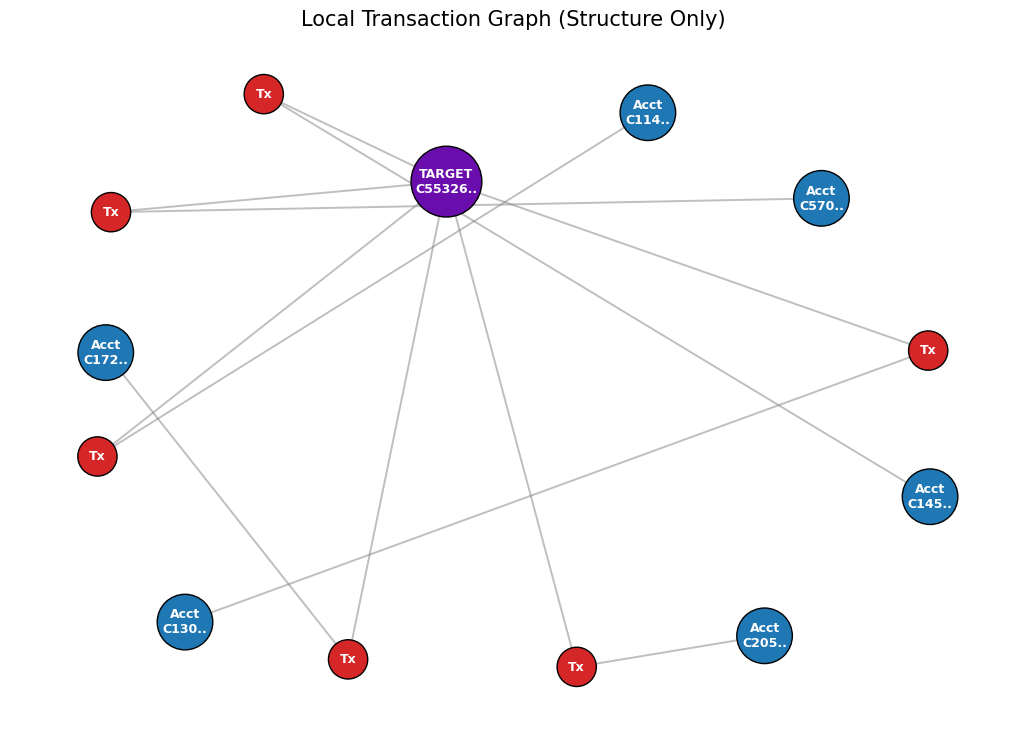

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

def visualize_account_network(target_acc_id):
    print(f"Building network for account: {target_acc_id}...")
    
    # 1. Find the Account Index
    try:
        target_idx = account_encoder.transform([target_acc_id])[0]
    except ValueError:
        print(f"❌ Account {target_acc_id} not found in graph.")
        return

    G = nx.Graph()

    # ----------------------------
    # NODE SIZE CONVENTION
    # ----------------------------
    SIZE_MAIN_ACCOUNT = 2600
    SIZE_ACCOUNT = 1600
    SIZE_TRANSACTION = 800

    # ----------------------------
    # CENTRAL (EGO) ACCOUNT
    # ----------------------------
    G.add_node(
        "Main",
        color="#6A0DAD",
        size=SIZE_MAIN_ACCOUNT,
        label=f"TARGET\n{target_acc_id[:6]}..",
        font_color="white"
    )

    # ==========================================
    # 2. OUTGOING TRANSACTIONS
    # ==========================================
    sends_edge = data['account', 'sends', 'transaction'].edge_index
    sent_tx_indices = sends_edge[1][sends_edge[0] == target_idx]
    print(f"→ Found {len(sent_tx_indices)} outgoing transactions")

    for i, tx_idx in enumerate(sent_tx_indices[:6]):
        tx_idx = tx_idx.item()
        tx_node = f"Tx_Out_{i}"

        # Transaction node (small)
        G.add_node(
            tx_node,
            color="#D62728",
            size=SIZE_TRANSACTION,
            label="Tx",
            font_color="white"
        )
        G.add_edge("Main", tx_node)

        # Receiver account
        receives_edge = data['transaction', 'receives', 'account'].edge_index
        recv_idx = receives_edge[1][receives_edge[0] == tx_idx].item()
        recv_id = account_encoder.inverse_transform([recv_idx])[0]
        recv_node = f"Recv_{i}"

        G.add_node(
            recv_node,
            color="#FF8C00",
            size=SIZE_ACCOUNT,
            label=f"Acct\n{recv_id[:4]}..",
            font_color="black"
        )
        G.add_edge(tx_node, recv_node)

    # ==========================================
    # 3. INCOMING TRANSACTIONS
    # ==========================================
    receives_edge = data['transaction', 'receives', 'account'].edge_index
    received_tx_indices = receives_edge[0][receives_edge[1] == target_idx]
    print(f"→ Found {len(received_tx_indices)} incoming transactions")

    for i, tx_idx in enumerate(received_tx_indices[:6]):
        tx_idx = tx_idx.item()
        tx_node = f"Tx_In_{i}"

        G.add_node(
            tx_node,
            color="#D62728",
            size=SIZE_TRANSACTION,
            label="Tx",
            font_color="white"
        )
        G.add_edge(tx_node, "Main")

        # Sender account
        sends_edge = data['account', 'sends', 'transaction'].edge_index
        sender_idx = sends_edge[0][sends_edge[1] == tx_idx].item()
        sender_id = account_encoder.inverse_transform([sender_idx])[0]
        sender_node = f"Sender_{i}"

        G.add_node(
            sender_node,
            color="#1F77B4",
            size=SIZE_ACCOUNT,
            label=f"Acct\n{sender_id[:4]}..",
            font_color="white"
        )
        G.add_edge(sender_node, tx_node)

    # ==========================================
    # 4. DRAW (CLEAN LAYOUT)
    # ==========================================
    plt.figure(figsize=(13, 9))
    pos = nx.spring_layout(G, seed=42, k=2.5)

    node_colors = [G.nodes[n]['color'] for n in G.nodes()]
    node_sizes = [G.nodes[n]['size'] for n in G.nodes()]
    labels = nx.get_node_attributes(G, 'label')
    font_colors = nx.get_node_attributes(G, 'font_color')

    nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.5, width=1.4)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors="black")

    for n, (x, y) in pos.items():
        plt.text(
            x, y, labels[n],
            fontsize=9,
            fontweight="bold",
            ha="center",
            va="center",
            color=font_colors.get(n, "black")
        )

    plt.title("Local Transaction Graph (Structure Only)", fontsize=15)
    plt.axis("off")
    plt.show()

# TEST: Visualize the Mule Account found earlier
fraud_tx_idx = torch.where(data['transaction'].y == 1)[0][0]
receives_edge = data['transaction', 'receives', 'account'].edge_index
mule_account_idx = receives_edge[1][receives_edge[0] == fraud_tx_idx].item()
mule_account_id = account_encoder.inverse_transform([mule_account_idx])[0]

visualize_account_network(mule_account_id)

# Model and Loss Class build

In [13]:
# Model and Loss Class
print("\n--- Preparing Model and Loss Class ---")

class BinaryFocalLoss(torch.nn.Module):
    def __init__(self, gamma=FOCAL_GAMMA, alpha=FOCAL_ALPHA, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        
    def forward(self, logits, targets):
        p = torch.sigmoid(logits)
        targets = targets.float()
        p_t = p * targets + (1 - p) * (1 - targets)
        alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        focal_weight = alpha_factor * (1.0 - p_t).pow(self.gamma)
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        loss = focal_weight * bce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

class EdgeClassifier(torch.nn.Module):
    def __init__(self, tx_in, acc_in, hidden_dim=HIDDEN_DIM, conv_layers=CONV_LAYERS, dropout=DROPOUT, metadata=None):
        super().__init__()
        self.tx_lin = Linear(tx_in, hidden_dim)
        self.acc_lin = Linear(acc_in, hidden_dim)
        
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        
        edge_types = metadata[1]
        for _ in range(conv_layers):
            conv_dict = {edge: SAGEConv((-1, -1), hidden_dim) for edge in edge_types}
            self.convs.append(HeteroConv(conv_dict, aggr='sum'))
            self.bns.append(torch.nn.BatchNorm1d(hidden_dim))
            
        # MLP for final classification
        self.edge_mlp = torch.nn.Sequential(
            Linear(2 * hidden_dim + tx_in, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            Linear(hidden_dim, 1)
        )
        self.edge_dropout_p = EDGE_DROPOUT_P

    def forward(self, x_dict, edge_index_dict, sender_indices=None, receiver_indices=None, tx_raw=None, apply_edge_dropout=True):
        # Fail-safe device detection
        device = self.tx_lin.weight.device
        
        # 1. Edge Dropout
        if apply_edge_dropout and self.edge_dropout_p > 0.0:
            edge_index_dict_mod = {k: drop_edges(ei.to(device), p=self.edge_dropout_p) for k, ei in edge_index_dict.items()}
        else:
            edge_index_dict_mod = {k: ei.to(device) for k, ei in edge_index_dict.items()}

        # 2. Base Embeddings
        x = {k: v.to(device) for k, v in x_dict.items()}
        x['account'] = self.acc_lin(x['account']).relu()
        x['transaction'] = self.tx_lin(x['transaction']).relu()
        
        # 3. Message Passing (GNN)
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index_dict_mod)
            x = {k: F.dropout(self.bns[i](v).relu(), p=DROPOUT, training=self.training) for k, v in x.items()}
        
        # 4. Final Prediction (MLP)
        # Required for GNNExplainer to see the end-to-end impact
        if sender_indices is not None and receiver_indices is not None and tx_raw is not None:
            h_sender = x['account'][sender_indices.to(device)]
            h_receiver = x['account'][receiver_indices.to(device)]
            tx_features = tx_raw.to(device)
            
            # Create Tri-Vector: [Sender_GNN, Receiver_GNN, Transaction_Tabular]
            edge_repr = torch.cat([h_sender, h_receiver, tx_features], dim=1)
            return self.edge_mlp(edge_repr).squeeze(1)
            
        return x # Fallback: returns account/transaction embeddings

print("Classes built successfully.")


--- Preparing Model and Loss Class ---
Classes built successfully.


# Preparing the model, optimizer, indices and sampling probs

In [14]:
# Model, optimizer, and Sampler
							 
print("\n--- Model, Optimizer, and Sampler ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

tx_in = len(tx_feature_cols)
acc_in = len(acc_features_cols)
model = EdgeClassifier(tx_in, acc_in, hidden_dim=HIDDEN_DIM, conv_layers=CONV_LAYERS, dropout=DROPOUT, metadata=data.metadata())
			
# Transfer to device				
model = model.to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)
criterion_focal = BinaryFocalLoss(gamma=FOCAL_GAMMA, alpha=FOCAL_ALPHA).to(device)

print("Model components ready.")

# Prepare indices and Sampling Probs
tx_sender_global = data['transaction'].sender
tx_receiver_global = data['transaction'].receiver
tx_raw_all = data['transaction'].x
tx_labels = data['transaction'].y.squeeze(1).to(device)

train_idx = torch.nonzero(data['transaction'].train_mask, as_tuple=False).squeeze(1).cpu().numpy()
val_idx = torch.nonzero(data['transaction'].val_mask, as_tuple=False).squeeze(1).cpu().numpy()
test_idx = torch.nonzero(data['transaction'].test_mask, as_tuple=False).squeeze(1).cpu().numpy()
print("Train/Val/Test sizes:", len(train_idx), len(val_idx), len(test_idx))																		   

train_labels_arr = tx_labels[train_idx].cpu().numpy().astype(int)
base = np.where(train_labels_arr == 1, P_POS_MULTIPLIER, 1.0).astype(float)
sampling_probs = base / base.sum()

def get_sampled_train_idx(n_samples=None):
    if n_samples is None:
        n_samples = len(train_idx)
    sampled_positions = np.random.choice(len(train_idx), size=n_samples, replace=True, p=sampling_probs)
    return train_idx[sampled_positions]

print(f"Indices ready. Train set size: {len(train_idx)}")


--- Model, Optimizer, and Sampler ---
Device: cuda
Model components ready.
Train/Val/Test sizes: 2653729 78701 37979
Indices ready. Train set size: 2653729


# TRAIN loop (recompute per chunk)

In [15]:
# TRAIN loop
best_val_prauc = 0.0
patience_counter = 0

print("\n--- Starting Training (End-to-End Optimization) ---")
t_total = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_t0 = time.time()
    model.train()
    sampled_train_idx = get_sampled_train_idx()
    epoch_loss_sum = 0.0
    seen = 0

    for chunk in chunks(sampled_train_idx, CHUNK_SIZE):
        idx_tensor = torch.tensor(chunk, dtype=torch.long, device=device)
        
        # Forward call now produces logits directly
        logits = model(
            data.x_dict, 
            data.edge_index_dict, 
            sender_indices=tx_sender_global[idx_tensor],
            receiver_indices=tx_receiver_global[idx_tensor],
            tx_raw=tx_raw_all[idx_tensor],
            apply_edge_dropout=True
        )
        
        loss = criterion_focal(logits, tx_labels[idx_tensor])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss_sum += float(loss.item()) * len(chunk)
        seen += len(chunk)
        torch.cuda.empty_cache()

    avg_loss = epoch_loss_sum / max(1, seen)
    scheduler.step()

    # Validation Phase
    model.eval()
    probs_val_list = []
    y_val_true_list = []
    
    with torch.no_grad():
        for chunk in chunks(val_idx, CHUNK_SIZE):
            idx_tensor = torch.tensor(chunk, dtype=torch.long, device=device)
            logits = model(
                data.x_dict, data.edge_index_dict,
                sender_indices=tx_sender_global[idx_tensor],
                receiver_indices=tx_receiver_global[idx_tensor],
                tx_raw=tx_raw_all[idx_tensor],
                apply_edge_dropout=False
            )
            probs_val_list.append(torch.sigmoid(logits).cpu().numpy())
            y_val_true_list.append(tx_labels[idx_tensor].cpu().numpy())

    probs_val = np.concatenate(probs_val_list)
    y_val = np.concatenate(y_val_true_list)
    val_pr_auc = pr_auc_from_probs(y_val, probs_val)
    
    epoch_time = time.time() - epoch_t0
    print(f"Epoch {epoch:02d} | Train Loss {avg_loss:.5f} | Val PR-AUC {val_pr_auc:.5f} | {epoch_time:.1f}s")

    if val_pr_auc > best_val_prauc:
        best_val_prauc = val_pr_auc
        torch.save(model.state_dict(), "best_all_features_model.pth")
        patience_counter = 0
        print("  New best model saved.")
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        print("Early stopping triggered.")
        break

print(f"Training complete. Total time: {time.time() - t_total:.1f}s")


--- Starting Training (End-to-End Optimization) ---
Epoch 01 | Train Loss 0.04492 | Val PR-AUC 0.65723 | 20.8s
  New best model saved.
Epoch 02 | Train Loss 0.00649 | Val PR-AUC 0.82753 | 20.0s
  New best model saved.
Epoch 03 | Train Loss 0.00372 | Val PR-AUC 0.84261 | 20.0s
  New best model saved.
Epoch 04 | Train Loss 0.00294 | Val PR-AUC 0.84642 | 20.2s
  New best model saved.
Epoch 05 | Train Loss 0.00260 | Val PR-AUC 0.84647 | 20.3s
  New best model saved.
Epoch 06 | Train Loss 0.00237 | Val PR-AUC 0.84533 | 20.4s
Epoch 07 | Train Loss 0.00222 | Val PR-AUC 0.84575 | 20.4s
Epoch 08 | Train Loss 0.00213 | Val PR-AUC 0.84589 | 20.3s
Epoch 09 | Train Loss 0.00205 | Val PR-AUC 0.84667 | 20.3s
  New best model saved.
Epoch 10 | Train Loss 0.00201 | Val PR-AUC 0.84614 | 20.3s
Epoch 11 | Train Loss 0.00193 | Val PR-AUC 0.84551 | 20.4s
Epoch 12 | Train Loss 0.00192 | Val PR-AUC 0.84529 | 20.3s
Epoch 13 | Train Loss 0.00188 | Val PR-AUC 0.84451 | 20.3s
Epoch 14 | Train Loss 0.00182 | Val 

# Final evaluation

=== FINAL TEST RESULTS ===
Threshold: 0.60 | Test F1: 0.8272 | Test PR-AUC: 0.8710
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     36727
         1.0       0.85      0.81      0.83      1252

    accuracy                           0.99     37979
   macro avg       0.92      0.90      0.91     37979
weighted avg       0.99      0.99      0.99     37979



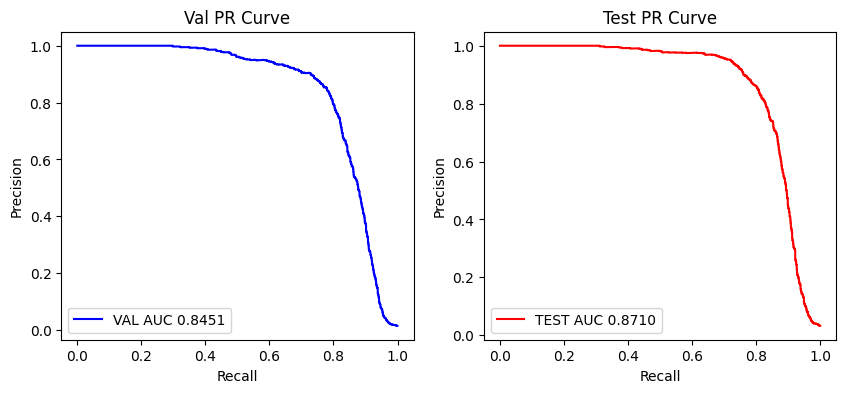

In [16]:
# Final Evaluation
model.load_state_dict(torch.load("best_all_features_model.pth", map_location=device))
model.eval()

# Generate Test Predictions
probs_test_list = []
y_test_true_list = []

with torch.no_grad():
    for chunk in chunks(test_idx, CHUNK_SIZE):
        idx_tensor = torch.tensor(chunk, dtype=torch.long, device=device)
        logits = model(
            data.x_dict, data.edge_index_dict,
            sender_indices=tx_sender_global[idx_tensor],
            receiver_indices=tx_receiver_global[idx_tensor],
            tx_raw=tx_raw_all[idx_tensor],
            apply_edge_dropout=False
        )
        probs_test_list.append(torch.sigmoid(logits).cpu().numpy())
        y_test_true_list.append(tx_labels[idx_tensor].cpu().numpy())

probs_test = np.concatenate(probs_test_list)
y_test = np.concatenate(y_test_true_list)

# Optimize Threshold on VAL set
# best_t, best_f1 = 0.5, 0.0
# for t in np.arange(0.01, 0.99, 0.01):
#     f1 = f1_score(y_val, (probs_val >= t).astype(int), zero_division=0)
#     if f1 > best_f1:
#         best_f1 = f1
#         best_t = t

best_t = 0.6
# Apply optimized threshold to TEST set
test_f1 = f1_score(y_test, (probs_test >= best_t).astype(int), zero_division=0)
test_pr_auc = pr_auc_from_probs(y_test, probs_test)

print("=== FINAL TEST RESULTS ===")
print(f"Threshold: {best_t:.2f} | Test F1: {test_f1:.4f} | Test PR-AUC: {test_pr_auc:.4f}")
print(classification_report(y_test, (probs_test >= best_t).astype(int), zero_division=0))

# Plot Precision-Recall Curves
precision_v, recall_v, _ = precision_recall_curve(y_val, probs_val)
precision_t, recall_t, _ = precision_recall_curve(y_test, probs_test)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(recall_v, precision_v, label=f"VAL AUC {auc(recall_v, precision_v):.4f}", color='blue')
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Val PR Curve"); plt.legend()

plt.subplot(1,2,2)
plt.plot(recall_t, precision_t, label=f"TEST AUC {auc(recall_t, precision_t):.4f}", color='red')
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Test PR Curve"); plt.legend()
plt.show()

# Artifacts Export 

In [18]:
# ============================================================
# ENHANCED ARTIFACT EXPORT FOR FRAUDXAI
# ============================================================
import torch
import joblib
import json
import os
import numpy as np
import pandas as pd

export_dir = "/kaggle/working/v3_artifacts"  # Version 3
os.makedirs(export_dir, exist_ok=True)
print(f"📁 Exporting enhanced artifacts to {export_dir}...")

# ============================================================
# 1. UI SEARCH DATA (unchanged)
# ============================================================
test_mask_arr = data['transaction'].test_mask.cpu().numpy()
test_indices = np.where(test_mask_arr)[0]

ui_search_df = df.iloc[test_indices].copy()
ui_search_df['gnn_prob'] = probs_test
ui_search_df['global_tx_idx'] = test_indices

ui_search_df = ui_search_df[[
    'global_tx_idx', 'hour_of_day', 'type', 'amount',
    'nameOrig', 'nameDest', 'isFraud', 'gnn_prob'
]]

ui_search_df.to_parquet(f"{export_dir}/ui_test_data.parquet", index=False)
print("✅ UI Search Data saved.")

# ============================================================
# 2. GNN MODEL ASSETS (unchanged)
# ============================================================
model_assets = {
    'state_dict': model.state_dict(),
    'hyperparams': {
        'in_channels_acc': len(acc_features_cols),
        'in_channels_tx': len(tx_feature_cols),
        'hidden_channels': HIDDEN_DIM,
        'conv_layers': CONV_LAYERS,
        'dropout': DROPOUT
    },
    'thresholds': {
        'high': 0.80,
        'medium': 0.60,
        'low': 0.49
    },
    'feature_names': tx_feature_cols
}

torch.save(model_assets, f"{export_dir}/model_assets.pt")
print("✅ GNN Model Assets saved.")

# ============================================================
# 3. GRAPH CONTEXT 
# ============================================================

graph_context = {
    # Original data
    'hetero_data': data.cpu(),
    'account_encoder': account_encoder,
    'tx_xgb_df': tx_xgb_df,
    'test_idx_map': {
        int(global_idx): int(local_idx)
        for local_idx, global_idx in enumerate(test_indices)
    }
}

joblib.dump(graph_context, f"{export_dir}/graph_context.pkl")
print("✅ Graph Context saved.")

# ============================================================
# 4. TABULAR MODEL (unchanged)
# ============================================================
joblib.dump(xgb_clf, f"{export_dir}/xgb_model.pkl")
print("✅ XGBoost model saved.")

# ============================================================
# 5. EXPORT SUMMARY
# ============================================================
print("\n" + "="*60)
print("📦 EXPORT SUMMARY")
print("="*60)
print(f"Export Directory: {export_dir}")
print(f"\nArtifacts:")
print(f"  ✅ ui_test_data.parquet")
print(f"  ✅ model_assets.pt")
print(f"  ✅ graph_context.pkl")
print(f"  ✅ xgb_model.pkl")
print("="*60)

📁 Exporting enhanced artifacts to /kaggle/working/v3_artifacts...
✅ UI Search Data saved.
✅ GNN Model Assets saved.
✅ Graph Context saved.
✅ XGBoost model saved.

📦 EXPORT SUMMARY
Export Directory: /kaggle/working/v3_artifacts

Artifacts:
  ✅ ui_test_data.parquet
  ✅ model_assets.pt
  ✅ graph_context.pkl
  ✅ xgb_model.pkl


In [19]:
import kagglehub
# 6. KAGGLEHUB UPLOAD
print("\n📡 Initiating KaggleHub Authentication...")
!export KAGGLE_API_TOKEN=KGAT_433590ccc558be3e1b178a842e8b678a
username = "shreyasgadder"
# Naming convention: {username}/{model_slug}/{framework}/{variation_slug}
# Ensure you created 'fraud-gnn-xai' in the Kaggle Models UI first.
MODEL_SLUG = "fraud-gnn-xai"
VARIATION_SLUG = "v5"
HANDLE = f"{username}/{MODEL_SLUG}/pyTorch/{VARIATION_SLUG}"

try:
    kagglehub.model_upload(HANDLE, export_dir, 'Apache 2.0')
    print(f"\n🚀 SUCCESS: Version '{VARIATION_SLUG}' is live at https://www.kaggle.com/models/{HANDLE}")
except Exception as e:
    print(f"\n❌ Upload failed: {e}")
    print("💡 Manual Step: Go to Kaggle.com > Models > New Model and create 'fraud-gnn-xai' first.")


📡 Initiating KaggleHub Authentication...
Uploading Model https://api.kaggle.com/models/shreyasgadder/fraud-gnn-xai/pyTorch/v5 ...


Uploading: 100%|██████████| 731M/731M [00:06<00:00, 117MB/s]  

Upload successful: /kaggle/working/v3_artifacts/graph_context.pkl (697MB)
Starting upload for file /kaggle/working/v3_artifacts/xgb_model.pkl



Uploading: 100%|██████████| 816k/816k [00:00<00:00, 1.97MB/s]

Upload successful: /kaggle/working/v3_artifacts/xgb_model.pkl (796KB)
Starting upload for file /kaggle/working/v3_artifacts/ui_test_data.parquet



Uploading: 100%|██████████| 1.60M/1.60M [00:00<00:00, 3.74MB/s]

Upload successful: /kaggle/working/v3_artifacts/ui_test_data.parquet (2MB)
Starting upload for file /kaggle/working/v3_artifacts/model_assets.pt



Uploading: 100%|██████████| 59.6k/59.6k [00:00<00:00, 141kB/s]

Upload successful: /kaggle/working/v3_artifacts/model_assets.pt (58KB)


Your model instance has been created.
Files are being processed...
See at: https://api.kaggle.com/models/shreyasgadder/fraud-gnn-xai/pyTorch/v5

🚀 SUCCESS: Version 'v5' is live at https://www.kaggle.com/models/shreyasgadder/fraud-gnn-xai/pyTorch/v5
